# Problem Overview - Alzheimer's

*References :*  
data-set : https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images  
The 7 stages of Alzheimer's: https://www.seniorguidance.org/senior-living/stages-of-dementia-and-alzheimers-disease/

## Alzheimer's disease

Alzheimer's disease is a progressive disease, where the symptoms of dementia gradually worsen over several years. In its early stages, memory loss is mild, but as the stages of Alzheimer's progress, individuals lose the ability to hold a conversation and react to their environment.
Current treatments for Alzheimer's disease cannot prevent Alzheimer's disease from progressing, they can only temporarily slow the worsening of dementia symptoms and improve the quality of life for people with Alzheimer's disease. and their caregivers.

![Alzheimer's disease progression](./assets/alheimers_progression.png)

Alzheimer's disease goes through many stages, which we can categorize as follows:
1. **Non Demented** - There are usually no signs or symptoms that the disease is present.
2. **Very Mild Demented** - Life can go on as normal at this point, with the exception of occasional mild memory loss.
3. **Mild Demented** - **~7 years** - Performance on cognitive and memory tests are affected, and doctors can instantly identify impaired cognitive function.
4. **Moderate Demented** - **~2 years** - Symptoms of dementia are clear at this stage, loved ones can help with daily tasks and ensure the patient is safe at any time.

The other stages of the disease are the clearest and therefore do not require detection by MRI, these stages are:

5. **Moderately Severe dementia** - **~1.5 years** - Patients begin to need help with many activities of daily living.
6. **Severely Demented** - **2.5 years** - Patients may require constant 24/7 supervision, some will experience hallucinations or paranoia and have difficulty falling asleep.
7. **Extremely Severe Demented** - Dementia is terminal, they may not have much longer to live. Patients lose their motor skills, their ability to communicate, and their ability to react to the environment

*Note: The 7 stages of dementia are not in neat and precise boxes. Some patients may experience the symptoms shown while others may differ slightly or even significantly.*

## Causes of Alzheimer's

Researchers have found that subtle changes occur in the brain long before the first signs of Alzheimer's disease-related memory loss appear, **brain damage begins a decade or more** before its effects become apparent.

![Alzheimer's disease and brain effects](./assets/brain.jpg)

Abnormal levels of **beta-amyloid**, a natural protein, build up in the brain and form **plaques between nerve cells**. Another naturally occurring protein, **tau**, accumulates inside nerve cells and creates **neurofibrillar tangles**, or twisted fibers. These toxic buildups of protein **prevent nerve cells, or neurons, from transmitting information** as they otherwise would. So they lose their connections to other nerve cells and **die over time**.


Brain damage linked to Alzheimer's disease appears to begin in the **hippocampus**, which is the area of ​​the brain responsible for forming memories. As the disease progresses, other areas of the brain are also affected and **begin to shrink**.<br>
In the final stage of the disease, the damage is extensive and **brain tissue has shrunk dramatically**.

## Alzheimer's early detection

Using **Magnetic Resonance Imaging (MRI)** scans & Deep Learning, we have the ability to identify and quantify the reduction of certain regions in the brain, enabling us to detect the subtle alterations that occur well in advance of the initial indications of memory loss associated with Alzheimer's disease. This can improve the likelihood of successful treatment.

In [51]:
from tensorflow.keras import models, layers, optimizers, metrics, Input, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16, xception, DenseNet201

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import os

plt.style.use('seaborn-darkgrid')

# Data Exploration

We check the number of samples in each category of our dataset. (First four stages : Non Demented, Very Mild Demented, Mild Demented, Moderate Demented)

In [4]:
def get_class_len(img_dir):
    val_len={}
    train_len={}
    test_len={}
    for dirname, _, filenames in os.walk(img_dir):
        dir = dirname.split(sep='/')
        if 'train' in dir and dir[-1] != 'train':
            train_len[dir[-1]] = len(os.listdir(dirname))
        elif 'validation' in dir and dir[-1] != 'validation':
            val_len[dir[-1]] = len(os.listdir(dirname))
        elif 'test' in dir and dir[-1] != 'test':
            test_len[dir[-1]] = len(os.listdir(dirname))
    
    return val_len, train_len, test_len

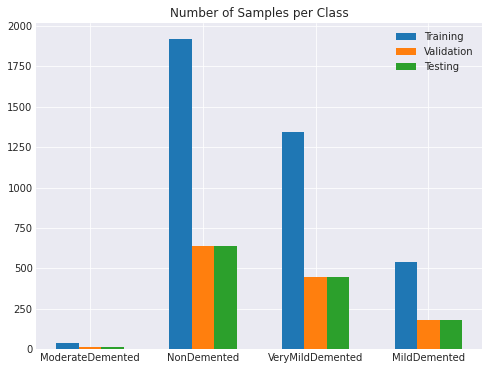

In [5]:
val_len, train_len, test_len = get_class_len('/kaggle/input/alzheimer-dataset')
X_axis = np.arange(4)

plt.figure(figsize=(8,6))
plt.bar(X_axis-0.2, train_len.values(),0.2, label="Training")
plt.bar(X_axis, val_len.values(), 0.2,label='Validation')
plt.bar(X_axis+0.2, test_len.values(),0.2, label='Testing')

plt.title("Number of Samples per Class")
plt.xticks(X_axis, val_len.keys())
plt.legend()
plt.show()

> The first thing we notice is that our data is unbalanced. For instance, the "ModerateDemented" contains only 40 training images, while other classes like "NonDemented" contains a larger number of images (1920 samples), and the same goes for validation and tests.

> Therefore we can't use **accuracy** as a training metric, so we use **Receiver Operating Characteristic curve (ROC curve)** as it is less affected by unbalanced datasets.

# Model Comparison - Convolutional Neural Networks (CNNs)

## Base Model

In [44]:
# building the model
base_model = models.Sequential()

base_model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
base_model.add(layers.MaxPooling2D((2,2)))
base_model.add(layers.Conv2D(64, (3,3), activation='relu'))
base_model.add(layers.MaxPooling2D((2,2)))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Conv2D(128, (3,3), activation='relu'))
base_model.add(layers.MaxPooling2D((2,2)))
base_model.add(layers.BatchNormalization())
base_model.add(layers.Conv2D(128, (3,3), activation='relu'))
base_model.add(layers.MaxPooling2D((2,2)))

base_model.add(layers.Flatten())
base_model.add(layers.Dropout(0.5))
base_model.add(layers.Dense(512, activation='relu'))
base_model.add(layers.Dropout(0.4))
base_model.add(layers.Dense(256, activation='relu'))
base_model.add(layers.Dropout(0.2))
base_model.add(layers.Dense(128, activation='relu'))
base_model.add(layers.Dense(4, activation='softmax'))

In [45]:
base_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 36, 36, 64)        256       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)     

In [46]:
# Compiling the model
base_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=[metrics.ROC(name='roc')])

In [47]:
# Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('train', target_size=(150,150), batch_size=20, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory('validation', target_size=(150,150), batch_size=20, class_mode='categorical')

Found 3842 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [48]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

In [49]:
# training the model
base_model_history = base_model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=20, validation_data=validation_generator, validation_steps=STEP_SIZE_VALID)

Epoch 1/20
192/192 [==============================] - 8s 39ms/step - loss: 1.5020 - auc: 0.7423 - val_loss: 1.1341 - val_auc: 0.7428
Epoch 2/20
192/192 [==============================] - 7s 37ms/step - loss: 1.0468 - auc: 0.7938 - val_loss: 1.0496 - val_auc: 0.8038
Epoch 3/20
192/192 [==============================] - 8s 39ms/step - loss: 0.9634 - auc: 0.8268 - val_loss: 0.9780 - val_auc: 0.8332
Epoch 4/20
192/192 [==============================] - 8s 43ms/step - loss: 0.8896 - auc: 0.8525 - val_loss: 0.9644 - val_auc: 0.8405
Epoch 5/20
192/192 [==============================] - 8s 42ms/step - loss: 0.8501 - auc: 0.8681 - val_loss: 1.0779 - val_auc: 0.8459
Epoch 6/20
192/192 [==============================] - 7s 37ms/step - loss: 0.7928 - auc: 0.8878 - val_loss: 2.3430 - val_auc: 0.7922
Epoch 7/20
192/192 [==============================] - 7s 36ms/step - loss: 0.7434 - auc: 0.9011 - val_loss: 0.9570 - val_auc: 0.8657
Epoch 8/20
192/192 [==============================] - 7s 37ms/step - 

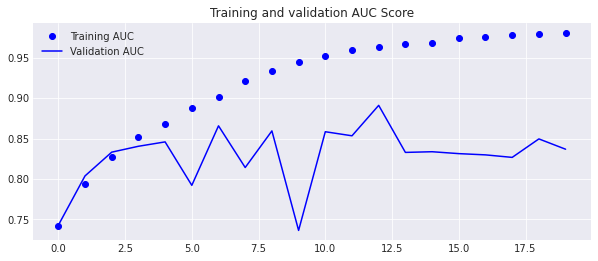

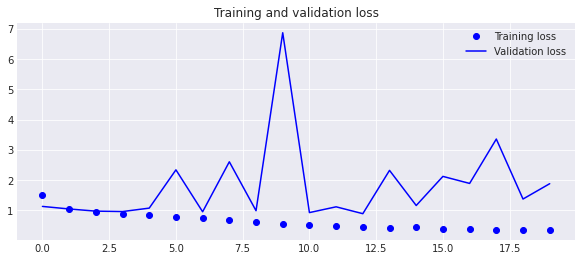

In [50]:
# Plotting history
base_model_history = base_model_history.history
epochs = range(len(base_model_history['auc']))

plt.figure(figsize=(10,4))
plt.plot(epochs, base_model_history['loss'], 'bo', label='Training loss')
plt.plot(epochs, base_model_history['val_loss'], 'b', label='Validation ROC')
plt.title('Training and validation loss')
plt.legend()

plt.figure(figsize=(10,4))
plt.plot(epochs, base_model_history['roc'], 'bo', label='Training AUC')
plt.plot(epochs, base_model_history['val_roc'], 'b', label='Validation ROC')
plt.title('Training and validation ROC Curve')
plt.legend()

plt.show()

> We notice that the model starts to overfit after the 10th epoch even when applying the dropout regularization.

> The best model evaluation AUC score is: 87%

## VGG16 (pretrained on imagenet)

In [13]:
vgg16_conv_base = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3)) 

58900480/58889256 [==============================] - 0s 0us/step


In [14]:
# connect densely connected classifier directly with base conv net
vgg16_model = models.Sequential()
vgg16_model.add(vgg16_conv_base)

vgg16_model.add(layers.Flatten())
vgg16_model.add(layers.Dropout(0.5))

vgg16_model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
vgg16_model.add(layers.Dense(4, activation='softmax'))

In [15]:
vgg16_conv_base.trainable = False

In [16]:
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 16,813,124
Trainable params: 2,098,436
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('train',target_size=(150, 150),batch_size=20, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory('validation',target_size=(150, 150),batch_size=20, class_mode='categorical')

Found 3842 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [18]:
vgg16_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=[metrics.ROC(name='roc')])

In [19]:
vgg16_model_history = vgg16_model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=20, validation_data=validation_generator, validation_steps=STEP_SIZE_VALID)

Epoch 1/20
192/192 [==============================] - 10s 45ms/step - loss: 1.3066 - auc: 0.7792 - val_loss: 1.0098 - val_auc: 0.8354
Epoch 2/20
192/192 [==============================] - 8s 44ms/step - loss: 0.9183 - auc: 0.8446 - val_loss: 0.9640 - val_auc: 0.8415
Epoch 3/20
192/192 [==============================] - 8s 43ms/step - loss: 0.8455 - auc: 0.8664 - val_loss: 0.8642 - val_auc: 0.8697
Epoch 4/20
192/192 [==============================] - 8s 42ms/step - loss: 0.7998 - auc: 0.8805 - val_loss: 0.8872 - val_auc: 0.8647
Epoch 5/20
192/192 [==============================] - 8s 43ms/step - loss: 0.7656 - auc: 0.8912 - val_loss: 0.8554 - val_auc: 0.8711
Epoch 6/20
192/192 [==============================] - 9s 46ms/step - loss: 0.7434 - auc: 0.8964 - val_loss: 1.0718 - val_auc: 0.8396
Epoch 7/20
192/192 [==============================] - 8s 44ms/step - loss: 0.7134 - auc: 0.9050 - val_loss: 0.9011 - val_auc: 0.8591
Epoch 8/20
192/192 [==============================] - 8s 43ms/step -

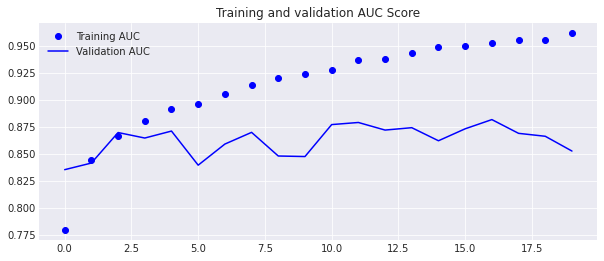

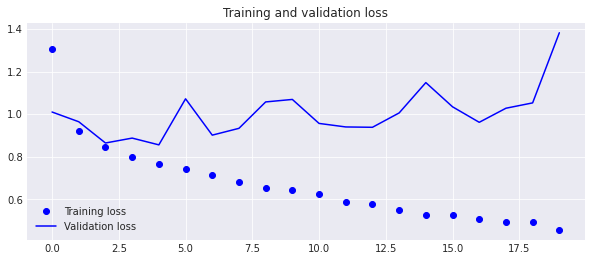

In [21]:
# Plotting history
vgg16_model_history = vgg16_model_history.history
epochs = range(len(vgg16_model_history['auc']))

plt.figure(figsize=(10,4))
plt.plot(epochs, vgg16_model_history['loss'], 'bo', label='Training loss')
plt.plot(epochs, vgg16_model_history['val_loss'], 'b', label='Validation ROC')
plt.title('Training and validation loss')
plt.legend()

plt.figure(figsize=(10,4))
plt.plot(epochs, vgg16_model_history['roc'], 'bo', label='Training AUC')
plt.plot(epochs, vgg16_model_history['val_roc'], 'b', label='Validation ROC')
plt.title('Training and validation ROC Curve')
plt.legend()

plt.show()

> This model has better generalisation, since it doesnt overfit. And still maintains the same top AUC score in validation of : 87%

### VGG16 + fine-tunning

In [22]:
# fine-tune the last three convolutional layers
vgg16_conv_base.trainable = True

set_trainable = False
for layer in vgg16_conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [23]:
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 16,813,124
Trainable params: 9,177,860
Non-trainable params: 7,635,264
_________________________________________________________________


In [24]:
vgg16_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-5), metrics=[metrics.ROC(name='roc')])

In [25]:
vgg16_finetunned_history = vgg16_model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=20, validation_data=validation_generator, validation_steps=STEP_SIZE_VALID)

Epoch 1/20
192/192 [==============================] - 11s 51ms/step - loss: 0.4141 - auc: 0.9682 - val_loss: 1.0896 - val_auc: 0.8822
Epoch 2/20
192/192 [==============================] - 9s 48ms/step - loss: 0.3461 - auc: 0.9776 - val_loss: 1.0872 - val_auc: 0.8877
Epoch 3/20
192/192 [==============================] - 9s 47ms/step - loss: 0.2769 - auc: 0.9862 - val_loss: 1.4433 - val_auc: 0.8685
Epoch 4/20
192/192 [==============================] - 9s 48ms/step - loss: 0.2369 - auc: 0.9896 - val_loss: 1.0499 - val_auc: 0.8875
Epoch 5/20
192/192 [==============================] - 9s 47ms/step - loss: 0.1981 - auc: 0.9928 - val_loss: 1.3052 - val_auc: 0.8651
Epoch 6/20
192/192 [==============================] - 9s 47ms/step - loss: 0.1733 - auc: 0.9947 - val_loss: 1.3926 - val_auc: 0.8748
Epoch 7/20
192/192 [==============================] - 9s 49ms/step - loss: 0.1435 - auc: 0.9961 - val_loss: 1.5418 - val_auc: 0.8791
Epoch 8/20
192/192 [==============================] - 9s 48ms/step -

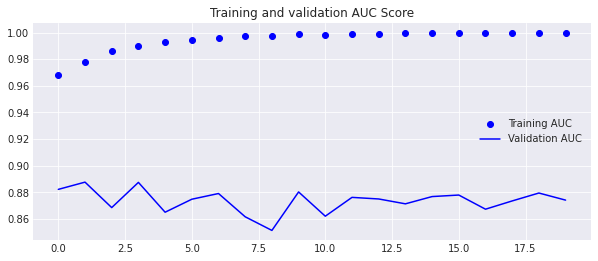

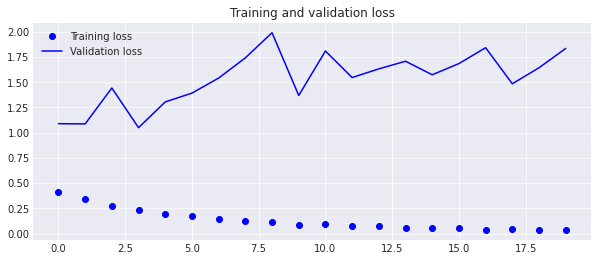

In [26]:
# Plotting history
vgg16_finetunned_history = vgg16_finetunned_history.history
epochs = range(len(vgg16_finetunned_history['auc']))

plt.figure(figsize=(10,4))
plt.plot(epochs, vgg16_finetunned_history['loss'], 'bo', label='Training loss')
plt.plot(epochs, vgg16_finetunned_history['val_loss'], 'b', label='Validation ROC')
plt.title('Training and validation loss')
plt.legend()

plt.figure(figsize=(10,4))
plt.plot(epochs, vgg16_finetunned_history['roc'], 'bo', label='Training AUC')
plt.plot(epochs, vgg16_finetunned_history['val_roc'], 'b', label='Validation ROC')
plt.title('Training and validation ROC Curve')
plt.legend()

plt.show()

> With finetunnig the model starts overfitting almost directly, even tho it reaches a top Evaluation AUC score of 90%

## Xception

In [27]:
xception_conv_base = xception.Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3)) 

83697664/83683744 [==============================] - 1s 0us/step


In [28]:
# connect densely connected classifier directly with base conv net
model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))


model.add(layers.Dense(256, activation='relu', input_dim=5*5*2048))
model.add(layers.Dense(4, activation='softmax'))

In [29]:
conv_base.trainable = False

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 1028      
Total params: 33,969,964
Trainable params: 13,108,484
Non-trainable params: 20,861,480
_________________________________________________________________


In [31]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('train',target_size=(150, 150),batch_size=20, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory('validation',target_size=(150, 150),batch_size=20, class_mode='categorical')

Found 3842 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [32]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(), metrics=[metrics.AUC(name='auc')])

In [33]:
history_4 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=20, validation_data=validation_generator, validation_steps=STEP_SIZE_VALID)

Epoch 1/20
192/192 [==============================] - 12s 51ms/step - loss: 8.8273 - auc: 0.6813 - val_loss: 6.5944 - val_auc: 0.6252
Epoch 2/20
192/192 [==============================] - 8s 44ms/step - loss: 3.8395 - auc: 0.7333 - val_loss: 4.0994 - val_auc: 0.6667
Epoch 3/20
192/192 [==============================] - 8s 44ms/step - loss: 1.8434 - auc: 0.7965 - val_loss: 1.7302 - val_auc: 0.8075
Epoch 4/20
192/192 [==============================] - 8s 44ms/step - loss: 1.1161 - auc: 0.8360 - val_loss: 0.9905 - val_auc: 0.8442
Epoch 5/20
192/192 [==============================] - 8s 44ms/step - loss: 0.8415 - auc: 0.8729 - val_loss: 0.9112 - val_auc: 0.8518
Epoch 6/20
192/192 [==============================] - 8s 43ms/step - loss: 0.7984 - auc: 0.8828 - val_loss: 0.9854 - val_auc: 0.8474
Epoch 7/20
192/192 [==============================] - 9s 46ms/step - loss: 0.7328 - auc: 0.9010 - val_loss: 0.9279 - val_auc: 0.8489
Epoch 8/20
192/192 [==============================] - 8s 44ms/step -

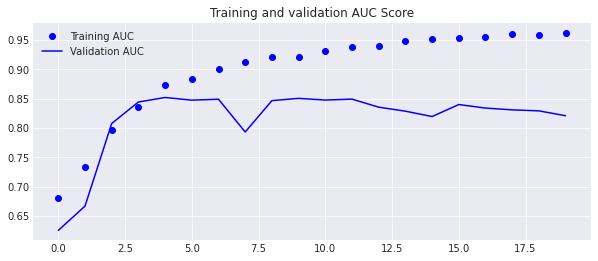

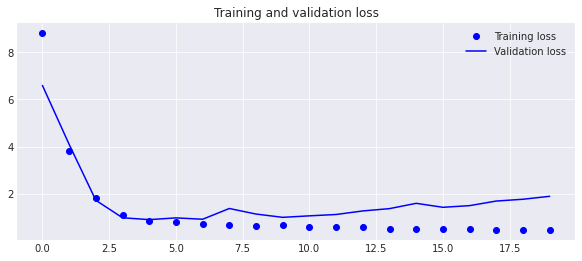

In [34]:
# Plotting history
history_4 = history_4.history
epochs = range(len(history_4['auc']))

plt.figure(figsize=(10,4))
plt.plot(epochs, history_4['auc'], 'bo', label='Training AUC')
plt.plot(epochs, history_4['val_auc'], 'b', label='Validation AUC')
plt.title('Training and validation AUC Score')
plt.legend()

plt.figure(figsize=(10,4))
plt.plot(epochs, history_4['loss'], 'bo', label='Training loss')
plt.plot(epochs, history_4['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## EfficientNet

In [91]:
conv_base = DenseNet201(weights='imagenet', include_top=False, input_shape=(150, 150, 3)) 

In [92]:
# connect densely connected classifier directly with base conv net
model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))


model.add(layers.Dense(256, activation='relu', input_dim=4*4*1920))
model.add(layers.Dense(4, activation='softmax'))

In [93]:
conv_base.trainable = False

In [94]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
flatten_9 (Flatten)          (None, 30720)             0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 30720)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               7864576   
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 1028      
Total params: 26,187,588
Trainable params: 7,865,604
Non-trainable params: 18,321,984
_________________________________________________________________


In [95]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('train',target_size=(150, 150),batch_size=20, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory('validation',target_size=(150, 150),batch_size=20, class_mode='categorical')

Found 3842 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [88]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)
lr_scheduler = callbacks.LearningRateScheduler(exponential_decay_fn)

early_callback = callbacks.EarlyStopping(monitor='val_auc', 
                               patience=10,
                               mode='max',
                               restore_best_weights=True)

In [96]:
model.compile(loss='categorical_crossentropy', optimizer="Adam",metrics=[metrics.AUC(name='auc')])

In [97]:
history_5 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,epochs=50, validation_data=validation_generator, validation_steps=STEP_SIZE_VALID)

Epoch 1/50
192/192 [==============================] - 25s 85ms/step - loss: 2.0631 - auc: 0.8122 - val_loss: 1.1776 - val_auc: 0.8438
Epoch 2/50
192/192 [==============================] - 13s 69ms/step - loss: 0.8199 - auc: 0.8841 - val_loss: 1.2200 - val_auc: 0.8263
Epoch 3/50
192/192 [==============================] - 13s 67ms/step - loss: 0.6750 - auc: 0.9177 - val_loss: 0.9185 - val_auc: 0.8672
Epoch 4/50
192/192 [==============================] - 13s 69ms/step - loss: 0.6294 - auc: 0.9278 - val_loss: 1.2204 - val_auc: 0.8430
Epoch 5/50
192/192 [==============================] - 14s 72ms/step - loss: 0.5943 - auc: 0.9354 - val_loss: 0.9263 - val_auc: 0.8731
Epoch 6/50
192/192 [==============================] - 13s 67ms/step - loss: 0.5805 - auc: 0.9382 - val_loss: 1.0247 - val_auc: 0.8669
Epoch 7/50
192/192 [==============================] - 14s 72ms/step - loss: 0.5557 - auc: 0.9435 - val_loss: 0.9193 - val_auc: 0.8785
Epoch 8/50
192/192 [==============================] - 13s 67ms

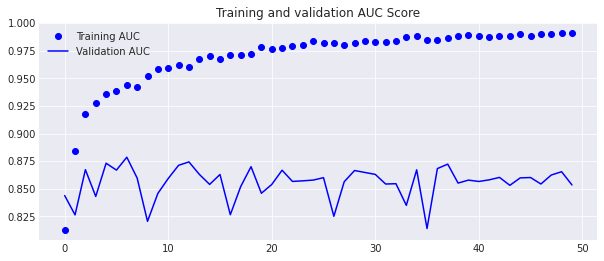

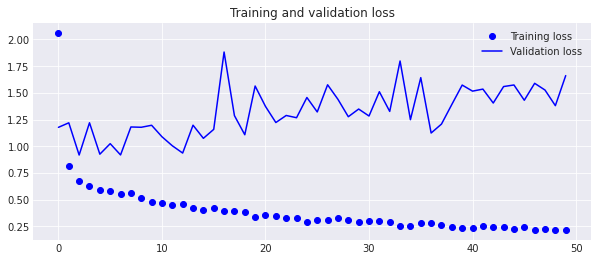

In [98]:
# Plotting history
history_5 = history_5.history
epochs = range(len(history_5['auc']))

plt.figure(figsize=(10,4))
plt.plot(epochs, history_5['auc'], 'bo', label='Training AUC')
plt.plot(epochs, history_5['val_auc'], 'b', label='Validation AUC')
plt.title('Training and validation AUC Score')
plt.legend()

plt.figure(figsize=(10,4))
plt.plot(epochs, history_5['loss'], 'bo', label='Training loss')
plt.plot(epochs, history_5['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

> The model starts ver fitting after 7th epoch, with a top AUC score of 87%